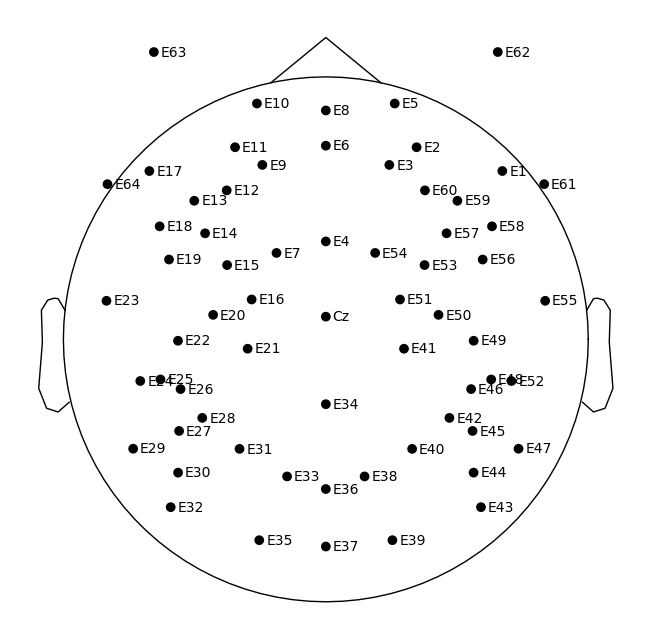

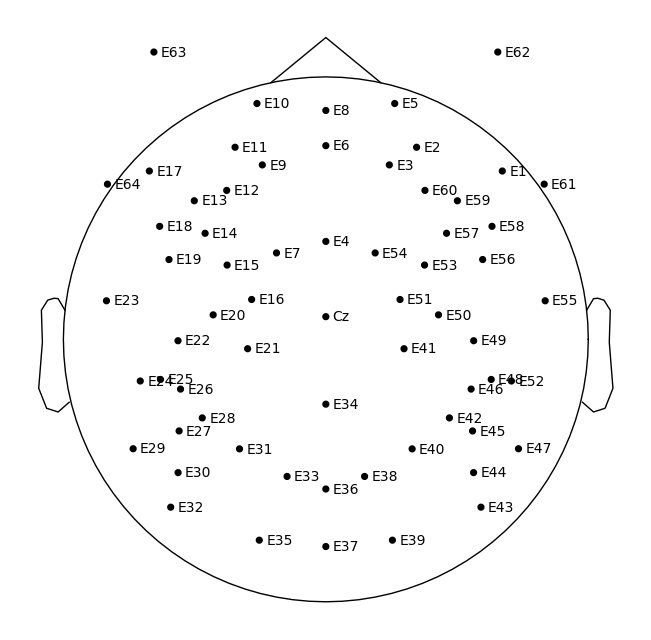

In [39]:
# importing the montage for the file 
from mne.channels import read_custom_montage

montage = read_custom_montage('GSN-HydroCel-65_1.0.sfp')
montage.plot()

# example of the analysis of one file after manual cleaning 

In [3]:
from mne.io import read_raw_eeglab

nt_9_listen = read_raw_eeglab('n9_listen_cleaned_manually.set', preload=True)

Reading C:\Users\mariy\Desktop\gsoc2025\n9_listen_cleaned_manually.fdt
Reading 0 ... 66205  =      0.000 ...   264.820 secs...


C:\Users\mariy\AppData\Local\Temp\ipykernel_14796\1124449990.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  nt_9_listen = read_raw_eeglab('n9_listen_cleaned_manually.set', preload=True)
C:\Users\mariy\AppData\Local\Temp\ipykernel_14796\1124449990.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  nt_9_listen = read_raw_eeglab('n9_listen_cleaned_manually.set', preload=True)


In [5]:
#before was just a function here, now extracted to preprocessing_functions.py

def convert_to_gsn_hydrocel_names(raw):
    """
    Convert channel names from 'EEG X' format to GSN-HydroCel-65_1.0 'EX' format in MNE,
    with special handling for VREF channel to be renamed as Cz.
    
    Parameters
    ----------
    raw : mne.io.Raw
        The raw EEG data with channels named as 'EEG X' and 'EEG VREF'
    
    Returns
    -------
    mne.io.Raw
        The raw data with renamed channels
    """
    # Create a mapping from old to new names
    channel_mapping = {}
    
    for ch_name in raw.ch_names:
        # Special case for VREF channel - rename to Cz
        if ch_name.upper() == 'EEG VREF':
            channel_mapping[ch_name] = 'Cz'
            continue
            
        if ch_name.startswith('EEG '):
            try:
                # Extract the channel number
                ch_num = int(ch_name.split(' ')[1])
                # Create new name in GSN-HydroCel format
                new_name = f'E{ch_num}'
                channel_mapping[ch_name] = new_name
            except (IndexError, ValueError):
                # Skip if the channel name doesn't match expected format
                print(f"Skipping channel {ch_name} - doesn't match 'EEG X' format")
                continue
    
    # Rename the channels
    raw.rename_channels(channel_mapping)
    
    return raw

In [7]:
nt_9_listen = convert_to_gsn_hydrocel_names(nt_9_listen)

In [9]:
nt_9_listen.set_montage(montage)

<RawEEGLAB | n9_listen_cleaned_manually.fdt, 65 x 66206 (264.8 s), ~32.9 MiB, data loaded>

# Finding and rejecting bad channels 

In [12]:
import numpy as np
import mne
from scipy import signal as signal
from time import perf_counter

from pyprep.find_noisy_channels import NoisyChannels

nc = NoisyChannels(nt_9_listen, random_state=1337)
nc.find_all_bads()

# Get the results
bad_channels = {
    'bad_by_nan': nc.bad_by_nan,
    'bad_by_flat': nc.bad_by_flat,
    'bad_by_deviation': nc.bad_by_deviation,
    'bad_by_hf_noise': nc.bad_by_hf_noise,
    'bad_by_correlation': nc.bad_by_correlation,
    'bad_by_ransac': nc.bad_by_ransac
}

print("Identified bad channels:")
for method, channels in bad_channels.items():
    print(f"{method}: {channels}")

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/52 [00:00<?,       ?it/s]


RANSAC done!
Identified bad channels:
bad_by_nan: []
bad_by_flat: ['Cz']
bad_by_deviation: ['E10']
bad_by_hf_noise: ['E55']
bad_by_correlation: ['E41']
bad_by_ransac: ['E63']


In [22]:
all_bads = list(set(
    nc.bad_by_nan + 
    nc.bad_by_flat + 
    nc.bad_by_deviation + 
    nc.bad_by_hf_noise + 
    nc.bad_by_correlation + 
    nc.bad_by_ransac
))

# Mark bad channels in the raw object
nt_9_listen.info['bads'] = all_bads

print(f"Marked {len(all_bads)} bad channels: {all_bads}")

Marked 5 bad channels: ['E55', 'E10', 'E41', 'E63', 'Cz']


In [24]:
# Interpolate the bad channels
nt_9_listen_interpolated = nt_9_listen.copy().interpolate_bads()

# Raw object without the bad channels
nt_9_listen_good = nt_9_listen.copy().drop_channels(nt_9_listen.info['bads'])

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.1 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 5 sensors


# Doing ICA 

In [28]:
from mne.preprocessing import ICA

ica = ICA(n_components=15, max_iter="auto", random_state=97, method='infomax')
ica.fit(nt_9_listen_interpolated.load_data())
ica

Fitting ICA to data using 65 channels (please be patient, this may take a while)


C:\Users\mariy\AppData\Local\Temp\ipykernel_33436\78146908.py:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(nt_9_listen_interpolated.load_data())


Selecting by number: 15 components
Computing Infomax ICA
Fitting ICA took 6.0s.


<ICA | raw data decomposition, method: infomax (fit in 500 iterations on 66206 samples), 15 ICA components (65 PCA components available), channel types: eeg, no sources marked for exclusion>

In [30]:
explained_var_ratio = ica.get_explained_variance_ratio(nt_9_listen_interpolated.load_data())
for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

Fraction of eeg variance explained by all components: 0.9761070767779328


In [32]:
explained_var_ratio = ica.get_explained_variance_ratio(
    nt_9_listen_interpolated, components=[0], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by first component: 18%


Creating RawArray with float64 data, n_channels=15, n_times=66206
    Range : 0 ... 66205 =      0.000 ...   264.820 secs
Ready.
Using matplotlib as 2D backend.


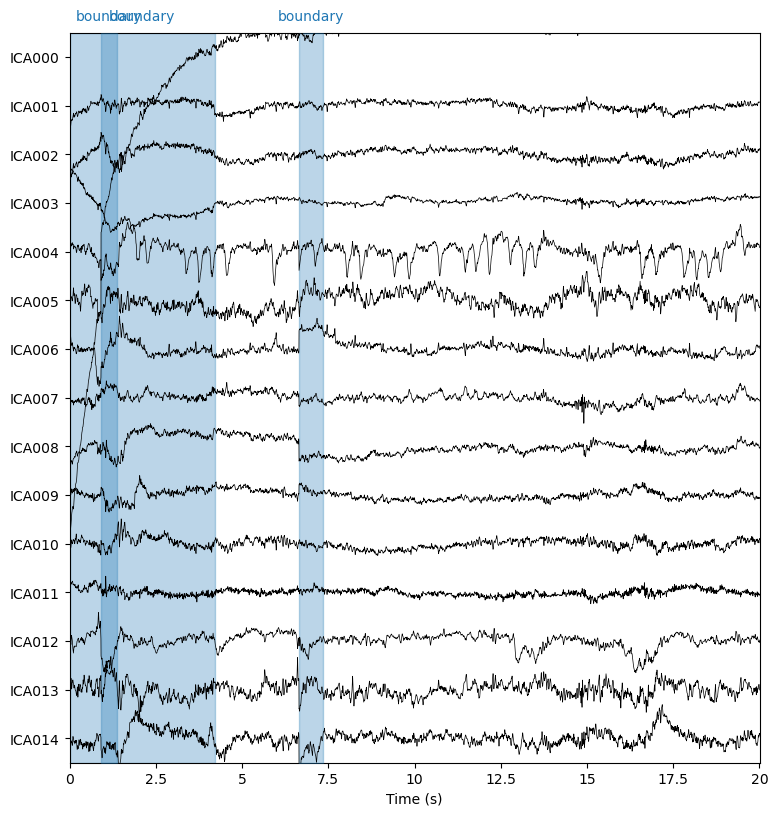

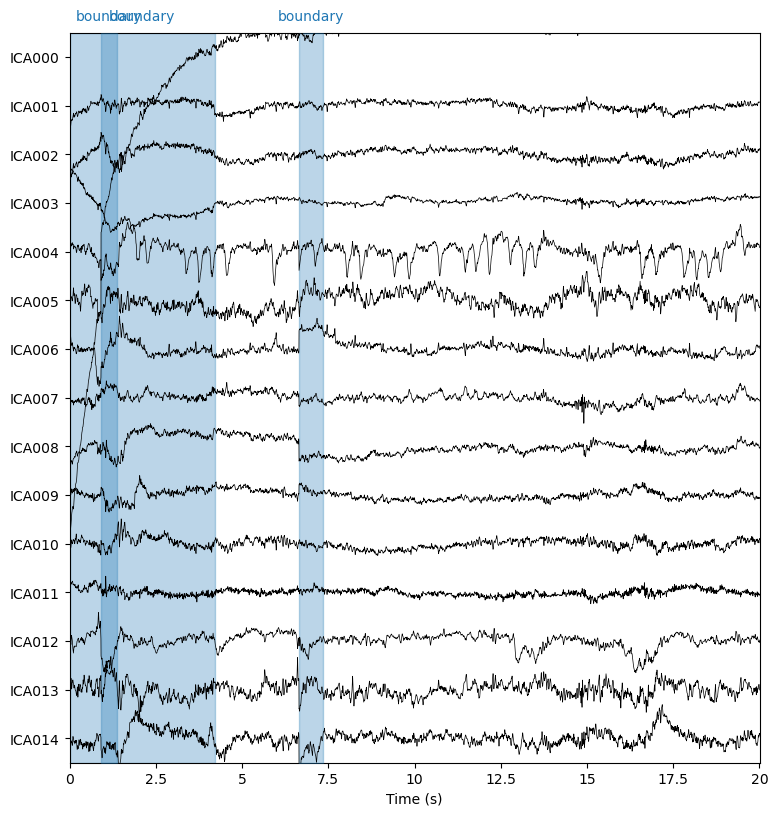

In [34]:
nt_9_listen_interpolated.load_data()
ica.plot_sources(nt_9_listen_interpolated, show_scrollbars=False)

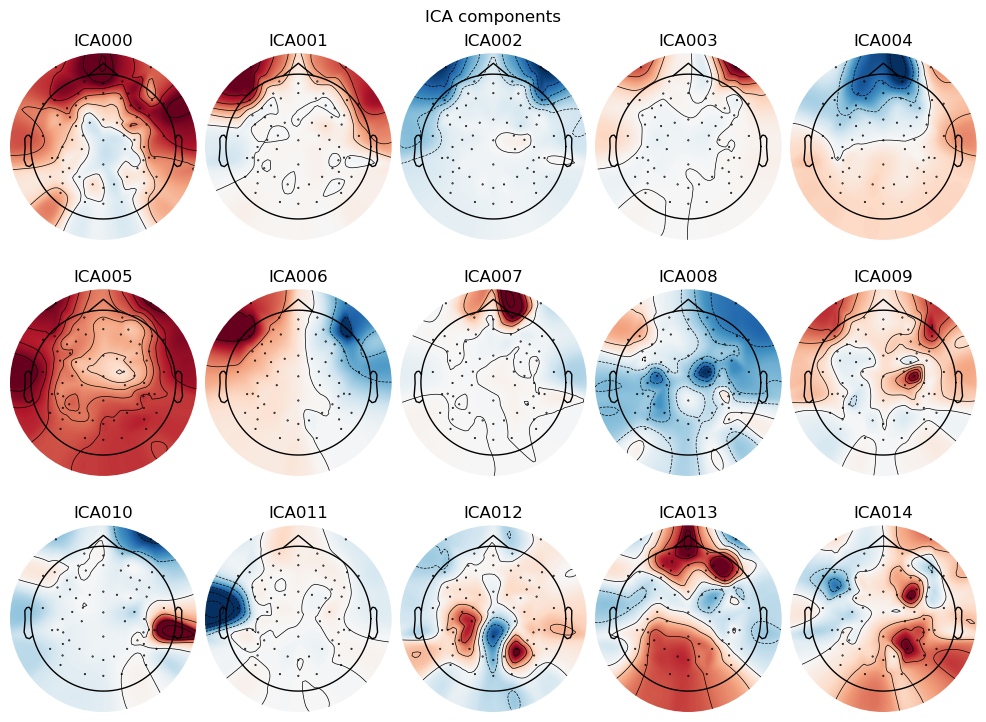

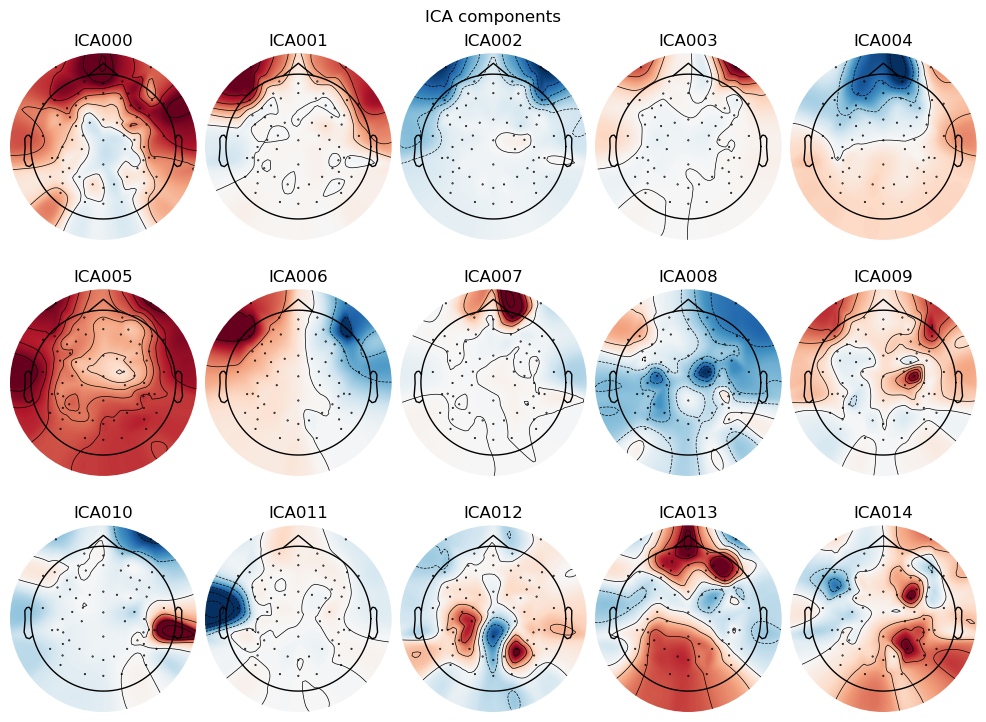

In [36]:
ica.plot_components()

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\mariy\anaconda3\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


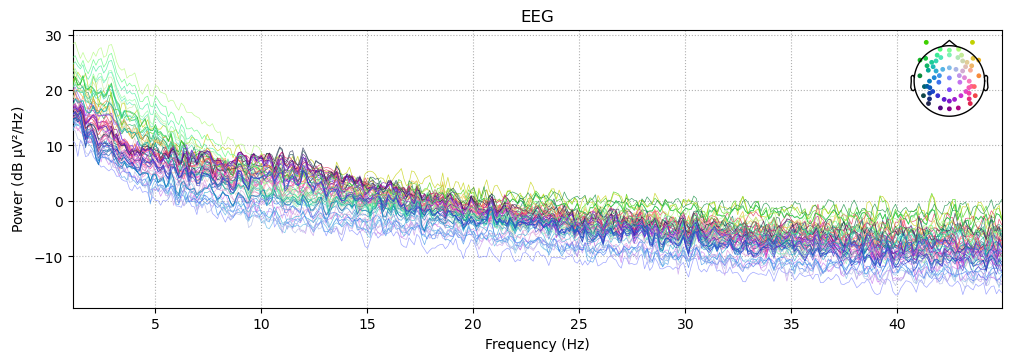

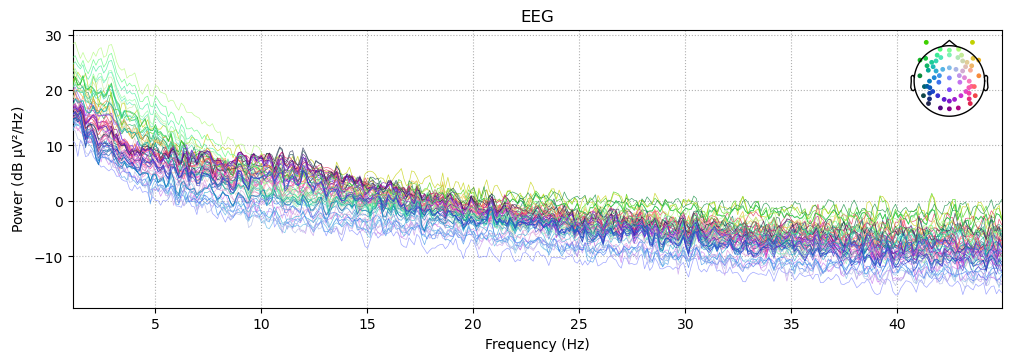

In [38]:
nt_9_listen_interpolated.compute_psd(fmin=1, fmax=45).plot()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated


C:\Users\mariy\AppData\Local\Temp\ipykernel_33436\381026710.py:1: UserWarning: Zero value in spectrum for channels ICA000, ICA001, ICA002, ICA007, ICA008, ICA013
  ica.plot_properties(nt_9_listen_interpolated, picks=list(range(0,15)))
C:\Users\mariy\AppData\Local\Temp\ipykernel_33436\381026710.py:1: UserWarning: Infinite value in PSD for epoch 131.
  ica.plot_properties(nt_9_listen_interpolated, picks=list(range(0,15)))


Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated


C:\Users\mariy\AppData\Local\Temp\ipykernel_33436\381026710.py:1: UserWarning: Infinite value in PSD for epoch 131.
  ica.plot_properties(nt_9_listen_interpolated, picks=list(range(0,15)))


Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated


C:\Users\mariy\AppData\Local\Temp\ipykernel_33436\381026710.py:1: UserWarning: Infinite value in PSD for epoch 131.
  ica.plot_properties(nt_9_listen_interpolated, picks=list(range(0,15)))


Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching eve

C:\Users\mariy\AppData\Local\Temp\ipykernel_33436\381026710.py:1: UserWarning: Infinite value in PSD for epoch 131.
  ica.plot_properties(nt_9_listen_interpolated, picks=list(range(0,15)))
C:\Users\mariy\AppData\Local\Temp\ipykernel_33436\381026710.py:1: UserWarning: Infinite value in PSD for epoch 131.
  ica.plot_properties(nt_9_listen_interpolated, picks=list(range(0,15)))


Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching eve

C:\Users\mariy\AppData\Local\Temp\ipykernel_33436\381026710.py:1: UserWarning: Infinite value in PSD for epoch 131.
  ica.plot_properties(nt_9_listen_interpolated, picks=list(range(0,15)))


Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated


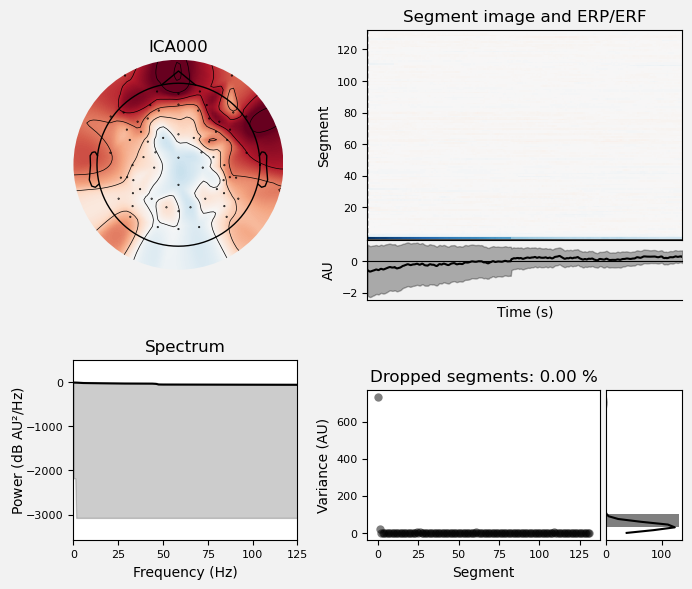

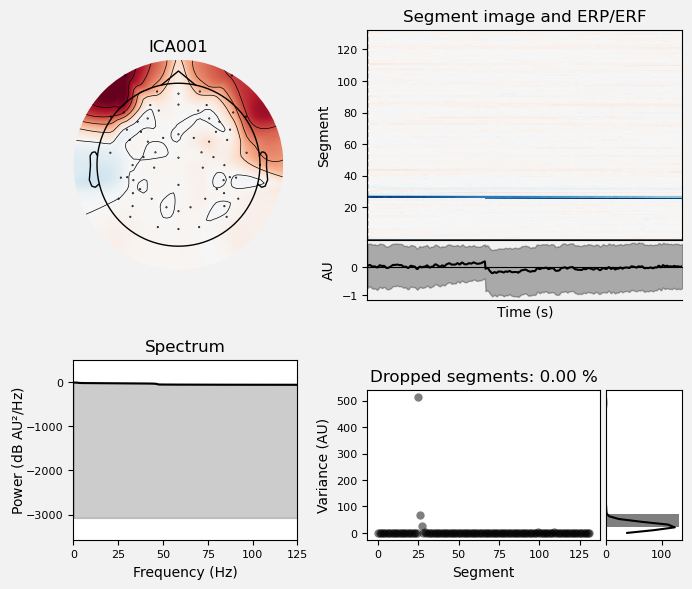

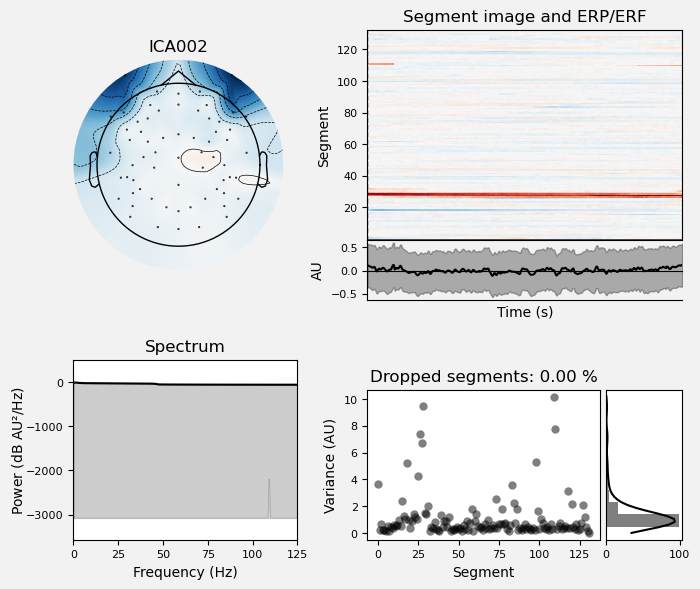

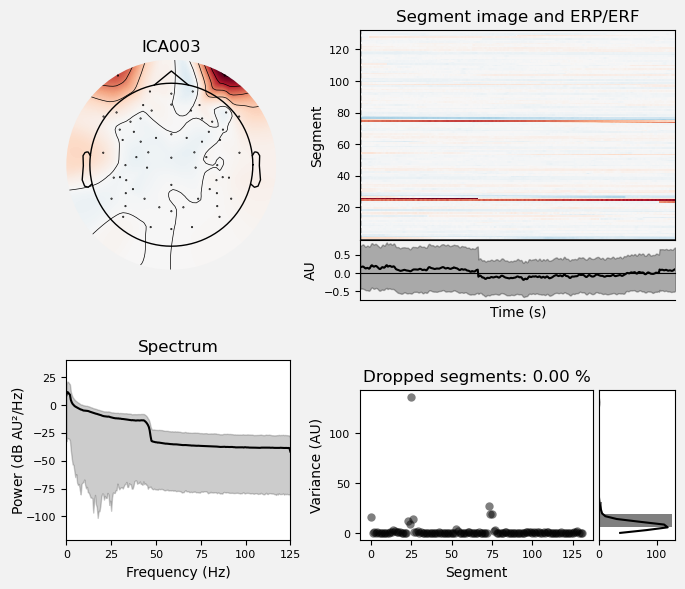

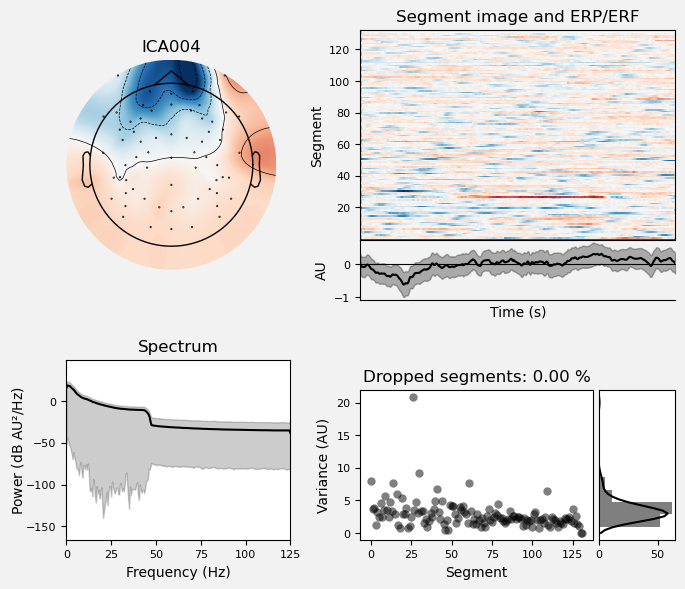

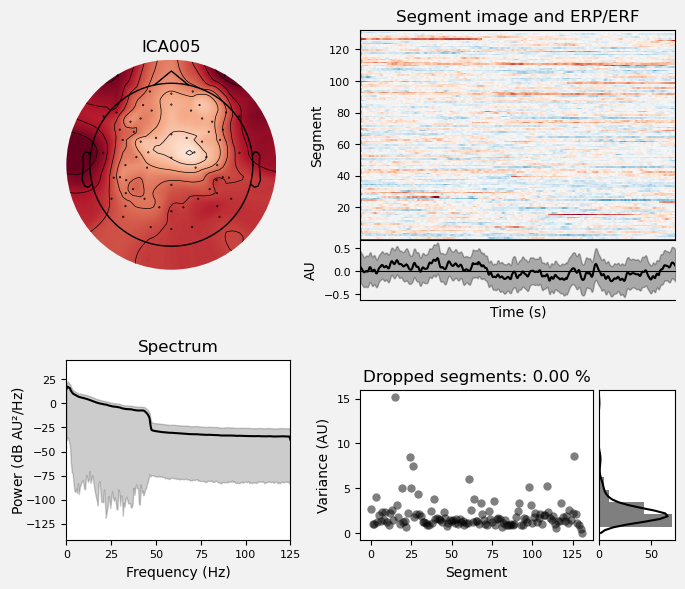

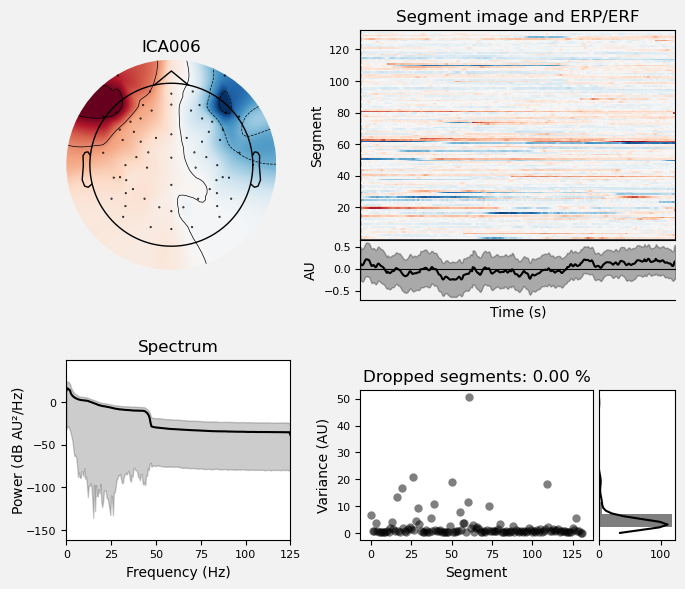

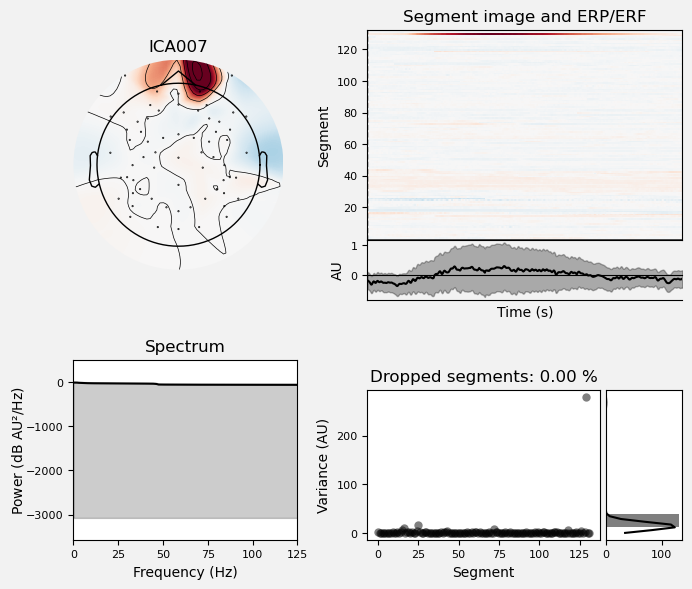

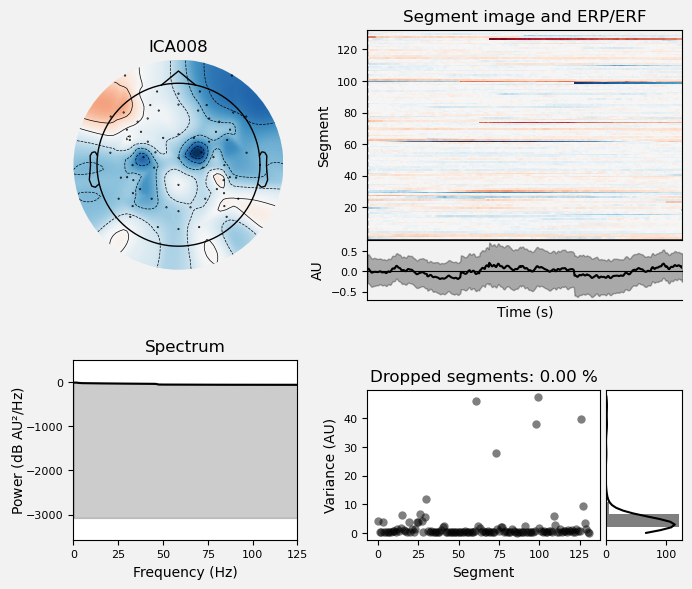

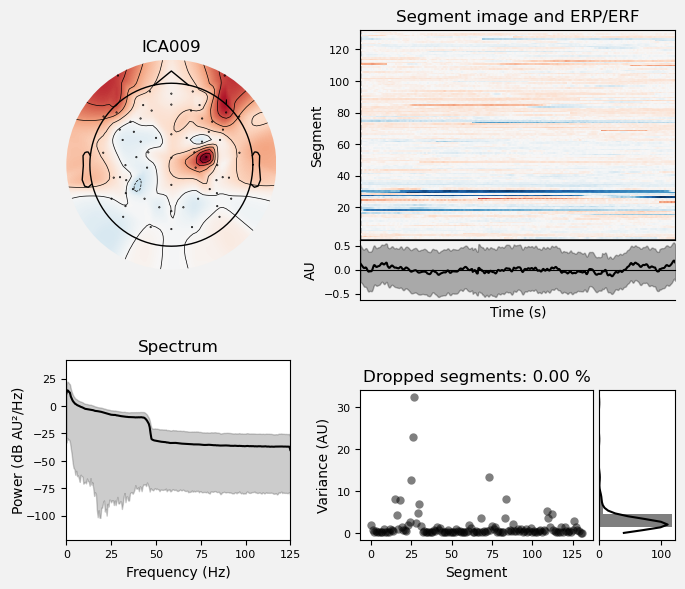

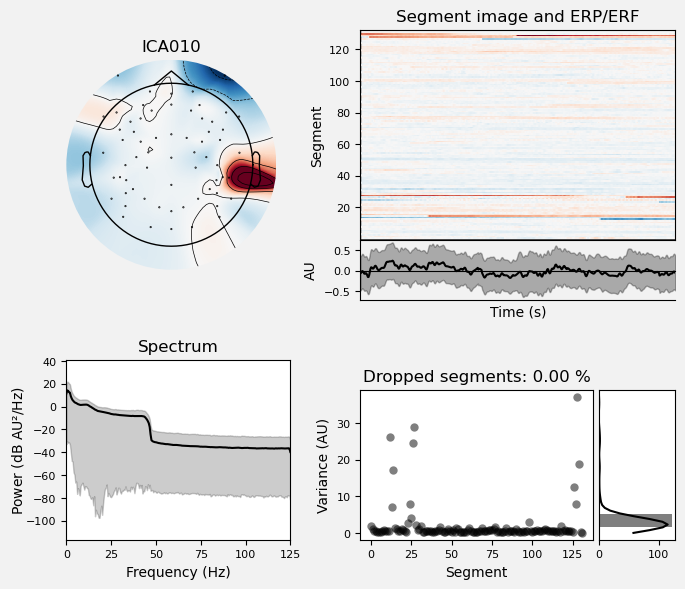

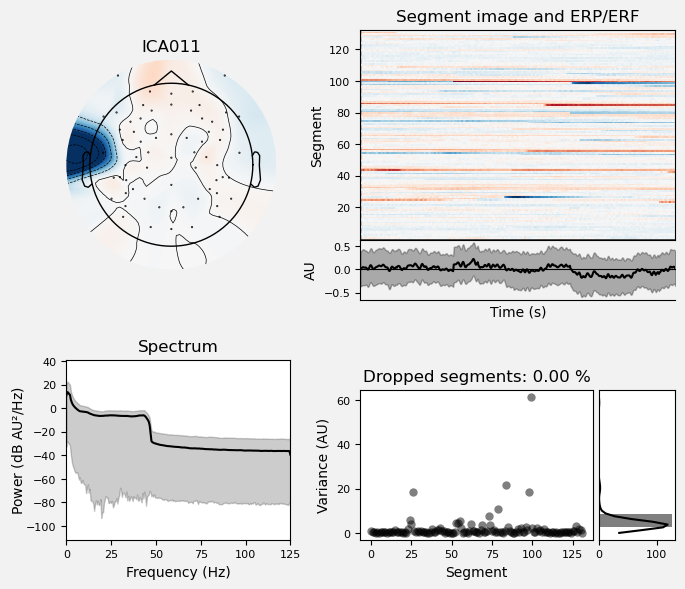

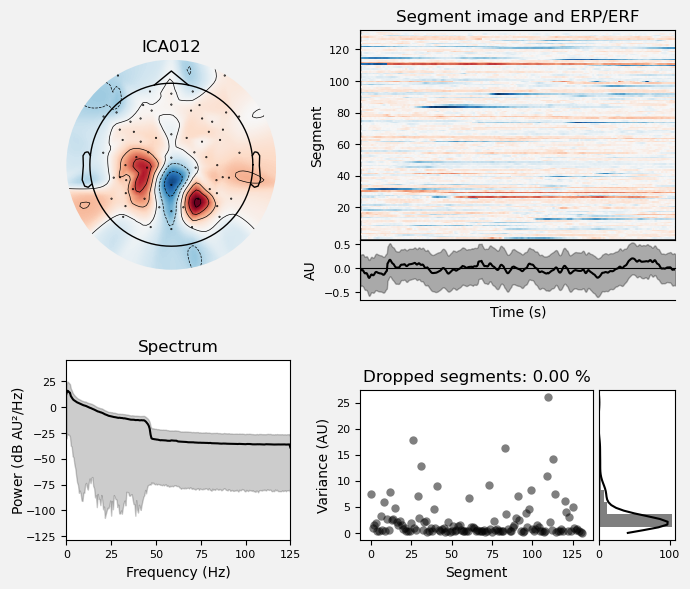

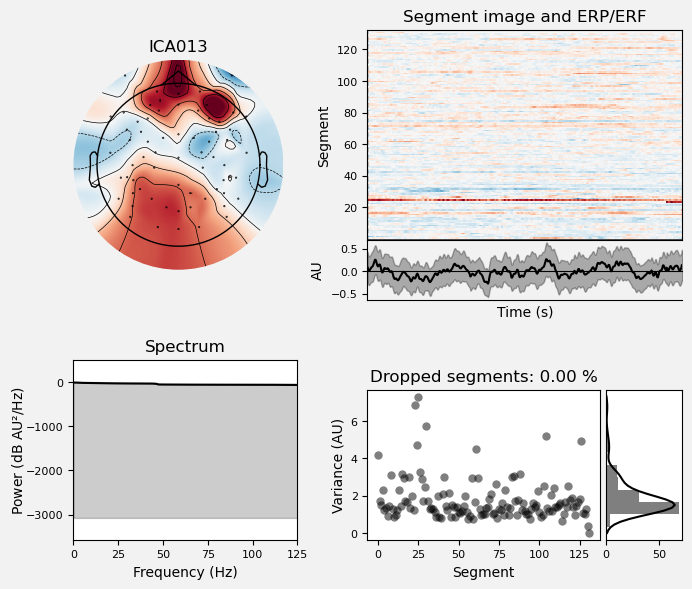

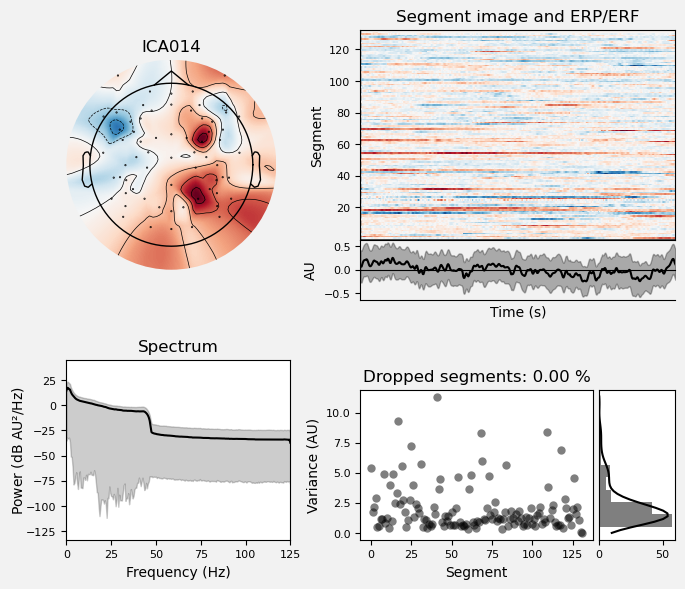

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [40]:
ica.plot_properties(nt_9_listen_interpolated, picks=list(range(0,15)))

In [42]:
ica.apply(nt_9_listen_interpolated, exclude=[0, 5, 10, 14])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 4 ICA components
    Projecting back using 65 PCA components


<RawEEGLAB | n9_listen_cleaned_manually.fdt, 65 x 66206 (264.8 s), ~32.9 MiB, data loaded>

# quick preprocessing script 

In [43]:
# the functions are now stored in preprocessing_functions.py for further usage 

def convert_to_gsn_hydrocel_names(raw):
    """
    Rename EEG channels from 'EEG X' format to 'EX' (GSN-HydroCel).
    VREF is renamed to 'Cz'.
    """
    mapping = {}
    for ch in raw.ch_names:
        if ch.upper() == 'EEG VREF':
            mapping[ch] = 'Cz'
        elif ch.startswith('EEG '):
            try:
                num = int(ch.split(' ')[1])
                mapping[ch] = f"E{num}"
            except:
                print(f"Skipping unrecognized channel: {ch}")
    raw.rename_channels(mapping)
    return raw

In [41]:
import mne
from mne.preprocessing import ICA
from mne.channels import read_custom_montage
from pyprep.find_noisy_channels import NoisyChannels
import os
import json
from datetime import datetime
import zipfile
import matplotlib.pyplot as plt

def preprocess_eeg(input_data, name=None, montage_path='GSN-HydroCel-65_1.0.sfp', output_dir='preprocessed_eeg/'):
    """
    Preprocess EEG data from a .set file or a Raw object and save as .edf after ICA.

    Parameters:
    - input_data: str or mne.io.Raw - path to EEGLAB .set file or already loaded Raw object
    - name: str - optional name used for output files when a Raw object is passed
    - montage_path: str - path to the montage .sfp file
    - output_dir: str - directory where the output EDF and log will be saved
    """
    os.makedirs(output_dir, exist_ok=True)

    processing_log = {
        'timestamp': datetime.now().isoformat(),
        'processing_steps': []
    }

    # Load data
    if isinstance(input_data, str):
        raw = mne.io.read_raw_eeglab(input_data, preload=True)
        processing_log['original_file'] = input_data
        base = os.path.splitext(os.path.basename(input_data))[0]
        processing_log['processing_steps'].append({
            'step': 'load_data',
            'description': f'Loaded EEG data from {input_data}',
            'n_channels': len(raw.ch_names),
            'duration_seconds': raw.times[-1]
        })
    elif isinstance(input_data, mne.io.BaseRaw):
        raw = input_data
        processing_log['original_file'] = 'Raw object provided directly'
        base = name if name else "raw_input"
        processing_log['processing_steps'].append({
            'step': 'use_raw_object',
            'description': 'Used already loaded Raw object',
            'n_channels': len(raw.ch_names),
            'duration_seconds': raw.times[-1]
        })
    else:
        raise ValueError("input_data must be a filepath string or an mne.io.Raw object")

    # Rename channels and set montage
    raw = convert_to_gsn_hydrocel_names(raw)
    montage = read_custom_montage(montage_path)
    raw.set_montage(montage)
    processing_log['processing_steps'].append({
        'step': 'set_montage',
        'description': f'Applied montage from {montage_path}',
        'montage_channels': montage.ch_names
    })

    # High-pass filter
    raw.filter(l_freq=1.0, h_freq=None)
    processing_log['processing_steps'].append({
        'step': 'highpass_filter',
        'description': 'Applied 1.0 Hz high-pass filter',
        'filter_settings': {'l_freq': 1.0, 'h_freq': None}
    })

    # Automatic bad channel detection using pyprep
    nc = NoisyChannels(raw, random_state=1337)
    nc.find_all_bads()

    bad_channels = {
        'bad_by_nan': nc.bad_by_nan,
        'bad_by_flat': nc.bad_by_flat,
        'bad_by_deviation': nc.bad_by_deviation,
        'bad_by_hf_noise': nc.bad_by_hf_noise,
        'bad_by_correlation': nc.bad_by_correlation,
        'bad_by_ransac': nc.bad_by_ransac
    }

    all_bads = list(set(
        nc.bad_by_nan +
        nc.bad_by_flat +
        nc.bad_by_deviation +
        nc.bad_by_hf_noise +
        nc.bad_by_correlation +
        nc.bad_by_ransac
    ))

    raw.info['bads'] = all_bads
    processing_log['processing_steps'].append({
        'step': 'bad_channel_detection',
        'description': 'Identified bad channels using pyprep',
        'bad_channels': bad_channels,
        'all_bad_channels': all_bads,
        'n_bad_channels': len(all_bads)
    })

    # Interpolate bad channels
    raw.interpolate_bads(reset_bads=True)
    processing_log['processing_steps'].append({
        'step': 'interpolate_bads',
        'description': 'Interpolated bad channels',
        'interpolated_channels': all_bads
    })

    # Ask user how many ICA components to use
    while True:
        try:
            n_components = int(input(f"Enter the number of ICA components to compute (recommended ≤ {len(raw.ch_names)}): "))
            break
        except ValueError:
            print("Invalid input. Please enter an integer.")

    # Run ICA
    ica = ICA(n_components=n_components, random_state=97, max_iter='auto')
    ica.fit(raw)
    processing_log['processing_steps'].append({
        'step': 'ica_fit',
        'description': 'Fitted ICA components',
        'ica_settings': {
            'n_components': n_components,
            'random_state': 97,
            'max_iter': 'auto'
        }
    })

    # Plot ICA components and save all figures as PNGs, then zip them
    print("Plotting ICA components and saving images...")
    ica_figs = ica.plot_components(show=True)
    
    png_paths = []

    for i, fig in enumerate(ica_figs):
        png_path = os.path.join(output_dir, f"{base}_ica_components_page{i+1}.png")
        fig.savefig(png_path, dpi=300)
        png_paths.append(png_path)

    zip_path = os.path.join(output_dir, f"{base}_ica_components.zip")
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for png_file in png_paths:
            zipf.write(png_file, arcname=os.path.basename(png_file))

    processing_log['processing_steps'].append({
        'step': 'ica_plot',
        'description': 'Saved ICA components figure for visual inspection',
        'n_components_plotted': n_components
    })

    # Ask user for components to exclude
    to_exclude = input("Enter ICA component numbers to exclude (comma-separated): ")
    to_exclude = [int(i.strip()) for i in to_exclude.split(',') if i.strip().isdigit()]
    ica.exclude = to_exclude
    processing_log['processing_steps'].append({
        'step': 'ica_component_selection',
        'description': 'User-selected ICA components to exclude',
        'excluded_components': to_exclude,
        'n_components_excluded': len(to_exclude)
    })

    # Apply ICA
    raw = ica.apply(raw.copy())
    processing_log['processing_steps'].append({
        'step': 'ica_apply',
        'description': 'Applied ICA cleaning',
        'n_components_removed': len(to_exclude)
    })

    # Save output
    output_path = os.path.join(output_dir, f"{base}_preprocessed.edf")
    mne.export.export_raw(output_path, raw, fmt='edf', overwrite=True)

    # Save processing log
    log_path = os.path.join(output_dir, f"{base}_processing_log.json")
    with open(log_path, 'w') as f:
        json.dump(processing_log, f, indent=4)

    print(f"Preprocessed file saved to: {output_path}")
    print(f"Processing log saved to: {log_path}")
    return output_path


In [ ]:
# things to do: 

# 1. put all the files on github -- this script, files before and after this preprocessing 
# 2. do a readme of all these, so it would be understandable 
# 3. put all the pics and questions into overleaf 
# 4. find a way to keep track of manual changes to make two versions of files 

**Let's try to see how the events of the cut work**

**cut all approach**

In [45]:
import numpy as np

def mutually_align_cuts(raw1, raw2):
    sfreq = raw1.info['sfreq']
    data1 = raw1.get_data().copy()
    data2 = raw2.get_data().copy()

    # 1. Pad the shorter file with zeros
    max_len = max(data1.shape[1], data2.shape[1])
    if data1.shape[1] < max_len:
        pad = np.zeros((data1.shape[0], max_len - data1.shape[1]))
        data1 = np.concatenate([data1, pad], axis=1)
    if data2.shape[1] < max_len:
        pad = np.zeros((data2.shape[0], max_len - data2.shape[1]))
        data2 = np.concatenate([data2, pad], axis=1)

    # 2. Insert zeros based on annotations
    def insert_zeros(data, annotations):
        for onset, duration in zip(annotations.onset, annotations.duration):
            start = int(onset * sfreq)
            stop = int((onset + duration) * sfreq)
            data[:, start:stop] = 0
        return data

    data1 = insert_zeros(data1, raw1.annotations)
    data2 = insert_zeros(data2, raw2.annotations)

    # 3. Identify zero regions
    zero_mask = np.all(data1 == 0, axis=0) | np.all(data2 == 0, axis=0)

    # 4. Find cut segments
    zero_diff = np.diff(np.concatenate(([0], zero_mask.astype(int), [0])))
    start_idxs = np.where(zero_diff == 1)[0]
    end_idxs = np.where(zero_diff == -1)[0]

    # 5. Create annotations
    new_annotations = []
    for start, end in zip(start_idxs, end_idxs):
        onset = start / sfreq
        duration = (end - start) / sfreq
        new_annotations.append((onset, duration))

    # 6. Define keep segments
    keep_segments = []
    current = 0
    for start, end in zip(start_idxs, end_idxs):
        if start > current:
            keep_segments.append((current, start))
        current = end
    if current < max_len:
        keep_segments.append((current, max_len))

    # 7. Rebuild both files
    def extract(data):
        return np.concatenate([data[:, s:e] for s, e in keep_segments], axis=1)

    new_data1 = extract(data1)
    new_data2 = extract(data2)

    # 8. Create new Raw objects
    raw1_clean = mne.io.RawArray(new_data1, raw1.info.copy())
    raw2_clean = mne.io.RawArray(new_data2, raw2.info.copy())

    # 9. Add shared annotations
    annots = mne.Annotations(
        onset=[a[0] for a in new_annotations],
        duration=[a[1] for a in new_annotations],
        description=['cut'] * len(new_annotations)
    )
    raw1_clean.set_annotations(annots)
    raw2_clean.set_annotations(annots)

    return raw1_clean, raw2_clean


In [47]:
from mne.io import read_raw_eeglab

nt_34_speak = read_raw_eeglab('nt34_speak.set', preload=True)
nt_34_speak = convert_to_gsn_hydrocel_names(nt_34_speak)

nt_35_speak = read_raw_eeglab('nt35_speak.set', preload=True)
nt_35_speak = convert_to_gsn_hydrocel_names(nt_35_speak)

nt_34_listen = read_raw_eeglab('nt34_listen.set', preload=True)
nt_34_listen = convert_to_gsn_hydrocel_names(nt_34_listen)

nt_35_listen = read_raw_eeglab('nt35_listen.set', preload=True)
nt_35_listen = convert_to_gsn_hydrocel_names(nt_35_listen)


Reading C:\Users\mariy\Desktop\gsoc2025\nt34_speak.fdt
Reading 0 ... 59165  =      0.000 ...   236.660 secs...
Reading C:\Users\mariy\Desktop\gsoc2025\nt35_speak.fdt
Reading 0 ... 55870  =      0.000 ...   223.480 secs...
Reading C:\Users\mariy\Desktop\gsoc2025\nt34_listen.fdt
Reading 0 ... 70452  =      0.000 ...   281.808 secs...


C:\Users\mariy\AppData\Local\Temp\ipykernel_360\2942933240.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  nt_34_speak = read_raw_eeglab('nt34_speak.set', preload=True)
C:\Users\mariy\AppData\Local\Temp\ipykernel_360\2942933240.py:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  nt_35_speak = read_raw_eeglab('nt35_speak.set', preload=True)


Reading C:\Users\mariy\Desktop\gsoc2025\nt35_listen.fdt
Reading 0 ... 63198  =      0.000 ...   252.792 secs...


C:\Users\mariy\AppData\Local\Temp\ipykernel_360\2942933240.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  nt_34_listen = read_raw_eeglab('nt34_listen.set', preload=True)
C:\Users\mariy\AppData\Local\Temp\ipykernel_360\2942933240.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  nt_35_listen = read_raw_eeglab('nt35_listen.set', preload=True)


In [49]:
nt34_listen_cut, nt35_speak_cut = mutually_align_cuts(nt_34_listen, nt_35_speak)
nt35_listen_cut, nt34_speak_cut = mutually_align_cuts(nt_35_listen, nt_34_speak)

Creating RawArray with float64 data, n_channels=65, n_times=36223
    Range : 0 ... 36222 =      0.000 ...   144.888 secs
Ready.
Creating RawArray with float64 data, n_channels=65, n_times=36223
    Range : 0 ... 36222 =      0.000 ...   144.888 secs
Ready.
Creating RawArray with float64 data, n_channels=65, n_times=38007
    Range : 0 ... 38006 =      0.000 ...   152.024 secs
Ready.
Creating RawArray with float64 data, n_channels=65, n_times=38007
    Range : 0 ... 38006 =      0.000 ...   152.024 secs
Ready.


C:\Users\mariy\AppData\Local\Temp\ipykernel_360\3241992810.py:70: RuntimeWarning: Omitted 24 annotation(s) that were outside data range.
  raw1_clean.set_annotations(annots)
C:\Users\mariy\AppData\Local\Temp\ipykernel_360\3241992810.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw1_clean.set_annotations(annots)
C:\Users\mariy\AppData\Local\Temp\ipykernel_360\3241992810.py:71: RuntimeWarning: Omitted 24 annotation(s) that were outside data range.
  raw2_clean.set_annotations(annots)
C:\Users\mariy\AppData\Local\Temp\ipykernel_360\3241992810.py:71: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw2_clean.set_annotations(annots)
C:\Users\mariy\AppData\Local\Temp\ipykernel_360\3241992810.py:70: RuntimeWarning: Omitted 37 annotation(s) that were outside data range.
  raw1_clean.set_annotations(annots)
C:\Users\mariy\AppData\Local\Temp\ipykernel_360\3241992810.py:70: RuntimeWarning: Limited 1 annotation(s

**cut only overlapping parts** 

In [51]:
import numpy as np
import mne

def pad_to_same_length(data1, data2):
    max_len = max(data1.shape[1], data2.shape[1])
    if data1.shape[1] < max_len:
        pad = np.zeros((data1.shape[0], max_len - data1.shape[1]))
        data1 = np.concatenate([data1, pad], axis=1)
    if data2.shape[1] < max_len:
        pad = np.zeros((data2.shape[0], max_len - data2.shape[1]))
        data2 = np.concatenate([data2, pad], axis=1)
    return data1, data2

def insert_zeros(data, annotations, sfreq):
    for onset, duration in zip(annotations.onset, annotations.duration):
        start = int(onset * sfreq)
        stop = int((onset + duration) * sfreq)
        data[:, start:stop] = 0
    return data

def _cut_and_return(raw1, raw2, data1, data2, zero_mask, sfreq):
    zero_diff = np.diff(np.concatenate(([0], zero_mask.astype(int), [0])))
    start_idxs = np.where(zero_diff == 1)[0]
    end_idxs = np.where(zero_diff == -1)[0]

    new_annotations = [
        (start / sfreq, (end - start) / sfreq)
        for start, end in zip(start_idxs, end_idxs)
    ]

    keep_segments = []
    current = 0
    for start, end in zip(start_idxs, end_idxs):
        if start > current:
            keep_segments.append((current, start))
        current = end
    if current < data1.shape[1]:
        keep_segments.append((current, data1.shape[1]))

    def extract(data):
        return np.concatenate([data[:, s:e] for s, e in keep_segments], axis=1)

    new_data1 = extract(data1)
    new_data2 = extract(data2)

    raw1_clean = mne.io.RawArray(new_data1, raw1.info.copy())
    raw2_clean = mne.io.RawArray(new_data2, raw2.info.copy())

    if new_annotations:
        annots = mne.Annotations(
            onset=[a[0] for a in new_annotations],
            duration=[a[1] for a in new_annotations],
            description=['cut'] * len(new_annotations)
        )
        raw1_clean.set_annotations(annots)
        raw2_clean.set_annotations(annots)

    return raw1_clean, raw2_clean


In [53]:
def mutually_align_cuts_overlap_only(raw1, raw2):
    sfreq = raw1.info['sfreq']
    data1 = raw1.get_data().copy()
    data2 = raw2.get_data().copy()

    data1, data2 = pad_to_same_length(data1, data2)

    data1 = insert_zeros(data1, raw1.annotations, sfreq)
    data2 = insert_zeros(data2, raw2.annotations, sfreq)

    zero_mask = np.all(data1 == 0, axis=0) & np.all(data2 == 0, axis=0)

    return _cut_and_return(raw1, raw2, data1, data2, zero_mask, sfreq)


In [55]:
nt34_listen_zeropad, nt35_speak_zeropad = mutually_align_cuts_overlap_only(nt_34_listen, nt_35_speak)
nt35_listen_zeropad, nt34_speak_zeropad = mutually_align_cuts_overlap_only(nt_35_listen, nt_34_speak)

Creating RawArray with float64 data, n_channels=65, n_times=65742
    Range : 0 ... 65741 =      0.000 ...   262.964 secs
Ready.
Creating RawArray with float64 data, n_channels=65, n_times=65742
    Range : 0 ... 65741 =      0.000 ...   262.964 secs
Ready.
Creating RawArray with float64 data, n_channels=65, n_times=57553
    Range : 0 ... 57552 =      0.000 ...   230.208 secs
Ready.
Creating RawArray with float64 data, n_channels=65, n_times=57553
    Range : 0 ... 57552 =      0.000 ...   230.208 secs
Ready.


C:\Users\mariy\AppData\Local\Temp\ipykernel_360\3982058998.py:55: RuntimeWarning: Omitted 18 annotation(s) that were outside data range.
  raw1_clean.set_annotations(annots)
C:\Users\mariy\AppData\Local\Temp\ipykernel_360\3982058998.py:56: RuntimeWarning: Omitted 18 annotation(s) that were outside data range.
  raw2_clean.set_annotations(annots)
C:\Users\mariy\AppData\Local\Temp\ipykernel_360\3982058998.py:55: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  raw1_clean.set_annotations(annots)
C:\Users\mariy\AppData\Local\Temp\ipykernel_360\3982058998.py:56: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  raw2_clean.set_annotations(annots)


In [71]:
preprocess_eeg(nt35_speak_zeropad, name='nt35_speak_zeropad')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


OSError: Too many noisy channels in the data to reliably perform RANSAC (only 0 good channels remaining, need at least 17).

In [ ]:
# faites: 

#1. 34 listen cut 
#2. 34 speak cut
#3. 34 listen zeropad
#4. 34 speak zeropad #too many noise channels (didn't do in the end) 

#1. 35 listen cut 
#2. 35 speak cut
#3. 35 listen zeropad
#4  35 speak zeropad #too many noisy channels 

In [75]:
len(nt35_speak_cut)

36223

In [79]:
len(nt_35_speak)

55871

In [81]:
len(nt35_speak_zeropad)

65742